## Netflix Movie Recommendation

### Business Problem

We want to recommend movies to users by
- By predicting the rating for a movie which has been unrated by the user
- Build a model with RMSE (between actual and predicted ratings) as the metric

The ratings prediction need not be calculated instantaneosly as these ratings would be precomputed on a daily basis (May be Nightly)

### Data

The dataset can be downloaded from https://www.kaggle.com/netflix-inc/netflix-prize-data

Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:

Columns : __CustomerID, Rating, Date__

- MovieIDs range from 1 to 17770 sequentially.
- CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
- Ratings are on a five star (integral) scale from 1 to 5.
- Dates have the format YYYY-MM-DD.

Movie information in "movie_titles.txt" is in the following format:

MovieID,YearOfRelease,Title

- MovieID do not correspond to actual Netflix movie ids or IMDB movie ids.
- YearOfRelease can range from 1890 to 2005 and may correspond to the release of corresponding DVD, not necessarily its theaterical release.
- Title is the Netflix movie title and may not correspond to titles used on other sites. Titles are in English.

### ML Problem

If we pose this a ML problem,we can categorize it as :
- Recommendation Problem to Recommend Movies
- Regression task to predict the ratings for an unrated movie

### Importing Libraries

In [125]:
import pandas as pd
import numpy as np
import os
from itertools import islice
import re
from tqdm import tqdm_notebook
from datetime import datetime

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy import sparse
from surprise import Reader,Dataset
from surprise import NormalPredictor
from surprise import SVD
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import BaselineOnly
from surprise import CoClustering
from surprise import NMF
from surprise.model_selection import cross_validate
from surprise.accuracy import rmse

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Exploratory Data Analysis

#### Data Preprocessing

In [2]:
# List all files 
for file in os.listdir('./data'):
    print('Filename: {0} --> {1}'.format(file.ljust(30).rstrip(),
                                       str(round(os.path.getsize('./data/'+file)/1000000,2))+'MB'))

Filename: .gitignore --> 0.0MB
Filename: .ipynb_checkpoints --> 0.0MB
Filename: all_data_combined.csv --> 2711.02MB
Filename: combined_data_1.txt --> 495.03MB
Filename: combined_data_2.txt --> 555.21MB
Filename: combined_data_3.txt --> 465.16MB
Filename: combined_data_4.txt --> 552.54MB
Filename: movie_titles.csv --> 0.58MB
Filename: probe.txt --> 10.78MB
Filename: qualifying.txt --> 52.45MB
Filename: sample_train_sparse_matrix.npz --> 0.24MB
Filename: test.csv --> 542.53MB
Filename: train.csv --> 2168.49MB
Filename: train_sparse.npz --> 167.42MB


In [3]:
# Sample Read
with open('./data/combined_data_1.txt') as file:
    head = list(islice(file,10))
print('First 10 rows: ......')
print([h for h in head])
file.close()

First 10 rows: ......
['1:\n', '1488844,3,2005-09-06\n', '822109,5,2005-05-13\n', '885013,4,2005-10-19\n', '30878,4,2005-12-26\n', '823519,3,2004-05-03\n', '893988,3,2005-11-17\n', '124105,4,2004-08-05\n', '1248029,3,2004-04-22\n', '1842128,4,2004-05-09\n']


In [4]:
# get all data files
files = [f for f in os.listdir('./data/') \
         if re.match('combined_data.*\.txt',f)]
files

['combined_data_1.txt',
 'combined_data_2.txt',
 'combined_data_3.txt',
 'combined_data_4.txt']

In [5]:
# Write a file with the final data
start_time = datetime.now()
if not os.path.isfile('./data/all_data_combined.csv'):
    all_data_combined = open('./data/all_data_combined.csv',mode = 'w')
# combine all the data into the format movieid','userid','rating','date'
    row = list()
    for file in tqdm(files):
        with open(os.path.join('./data/',file)) as f:
            for line in f:
                line = line.strip()
                if line.endswith(':'):
               # Then all that follow are ratings untill me revisit the same ':' pattern
                    movie_id = line.replace(':','')
                else:
                    row = [word for word in line.split(',')]
                    row.insert(0,movie_id)
                    all_data_combined.write(','.join(row))
                    all_data_combined.write('\n')
    all_data_combined.close()
    print('All data has been combined')
    print('Total Time Taken: {}'.format(datetime.now() - start_time))
                

#### Create a dataframe from the combined data

In [6]:
df = pd.read_csv('./data/all_data_combined.csv',sep = ',',names = ['movie','user','rating','date'])
df.head()

,movie,user,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


#### Sort the data

In [7]:
# lets sort the data by the data
df.sort_values(by='date',inplace=True)
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 56431994 to 25464092
Data columns (total 4 columns):
movie     int64
user      int64
rating    int64
date      object
dtypes: int64(3), object(1)
memory usage: 3.7+ GB


In [9]:
df.describe()

,movie,user,rating
count,1.004805e+08,1.004805e+08,1.004805e+08
mean,9.070915e+03,1.322489e+06,3.604290e+00
std,5.131891e+03,7.645368e+05,1.085219e+00
min,1.000000e+00,6.000000e+00,1.000000e+00
25%,4.677000e+03,6.611980e+05,3.000000e+00
50%,9.051000e+03,1.319012e+06,4.000000e+00
75%,1.363500e+04,1.984455e+06,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00


#### Check for any NaN values


In [10]:
df.isnull().sum()

movie     0
user      0
rating    0
date      0
dtype: int64

#### find duplicates, if any.

In [11]:
boolean = any(df.duplicated(subset=['movie','user','rating'])) 
boolean

False

There are no duplicates

#### Unique Records

In [12]:
print('Total unique users : ',df.user.nunique())
print('Total unique movies : ',df.movie.nunique())
print('Total ratings : ',df.shape[0])

Total unique users :  480189
Total unique movies :  17770
Total ratings :  100480507


#### Train/ Test Split

- As we have sorted the data in ascending order of dates, we will have the oldest ratings at the top and latest rating at the end.
- Here, we need to make use of the data's temporal (time) nature. We will use the older data everytime to make predictions for the future.
- The ratings model would be trained frequently on current day to day data and used to infer ratings for the future

In [13]:
%%timeit
if not os.path.isfile('./data/train.csv'):
    # First 80 % 
    train = df.iloc[:int(len(df)*0.80)]
    train.to_csv('./data/train.csv',index = False)
if not os.path.isfile('./data/test.csv'):
    # Remaining 20 %
    test = df.iloc[int(len(df)*0.80):]
    test.to_csv('./data/test.csv',index = False)


180 µs ± 9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
train_df = pd.read_csv("./data/train.csv",parse_dates = ['date'])

In [15]:
test_df = pd.read_csv("./data/test.csv",parse_dates = ['date'])

#### Check the distribution of the ratings in Train set

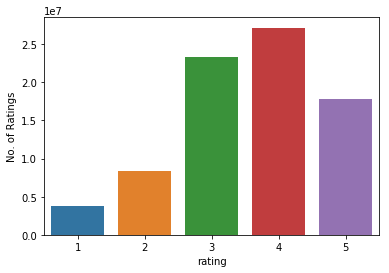

In [16]:
sns.countplot(train_df.rating)
plt.ylabel('No. of Ratings')
plt.show()

Most people rate 3 & 4. Very few people rate a movie as low as 1

We will add a column called a day_of_week and see if it can used to infer ratings

In [17]:
train_df['day_of_week'] = train_df.date.dt.weekday_name
train_df.head()

,movie,user,rating,date,day_of_week
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


#### Ratings per user

In [18]:
ratings_per_user_df = train_df.groupby(['user'])['rating'].count().sort_values(ascending=False)

ratings_per_user_df.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

A user has rated 17,112 times !

##### Plot the ratings per user in a PDF / CDF plot

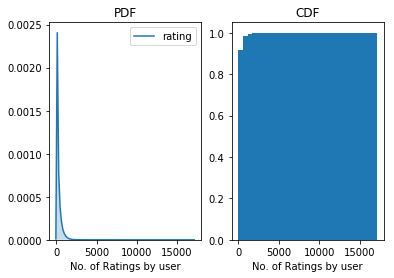

In [19]:
ax1 = plt.subplot(121)
sns.kdeplot(ratings_per_user_df,shade = True,ax = ax1)
plt.xlabel("No. of Ratings by user")
plt.title('PDF')

ax2 = plt.subplot(122)
plt.hist(ratings_per_user_df,cumulative=True, density=True, bins=30)

plt.xlabel("No. of Ratings by user")
plt.title('CDF')

plt.show()

Most users only rate a few movies

#### Ratings by day of the week

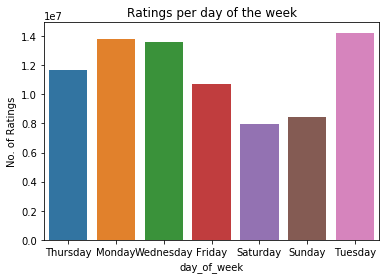

In [20]:
sns.countplot(train_df.day_of_week)
plt.ylabel('No. of Ratings')
plt.title('Ratings per day of the week')
plt.show()

Saturdays and Sundays have the least ratings in numbers as people tend to spend time outdoors

##### Box plot for ratings by the day of the week

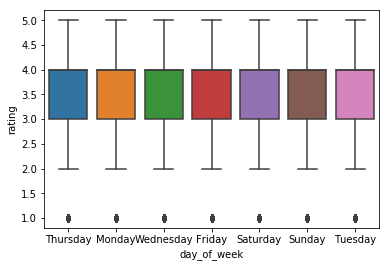

In [21]:
sns.boxplot(x= 'day_of_week', y = 'rating', data = train_df)
plt.show()

No , the feature day_of_week doesn't help us in identifying a rating given by a user for a movie

#### Create Sparse Matrix for the users and ratings

In [45]:
start = datetime.now()
if not os.path.isfile('./data/train_sparse.npz'):
    print('Creating Sparse Matrix for Training Data')
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values,(train_df.user.values,train_df.movie.values)),)
    print('Done: Shape of matrix : ',train_sparse_matrix.shape)
end = datetime.now()

print('Time taken : {}'.format(end-start))

Time taken : 0:00:00.000994


In [46]:
if not os.path.isfile('./data/train_sparse.npz'):
    sparse.save_npz('./data/train_sparse.npz',train_sparse_matrix)

#### Calculate Sparsity of the Matrix

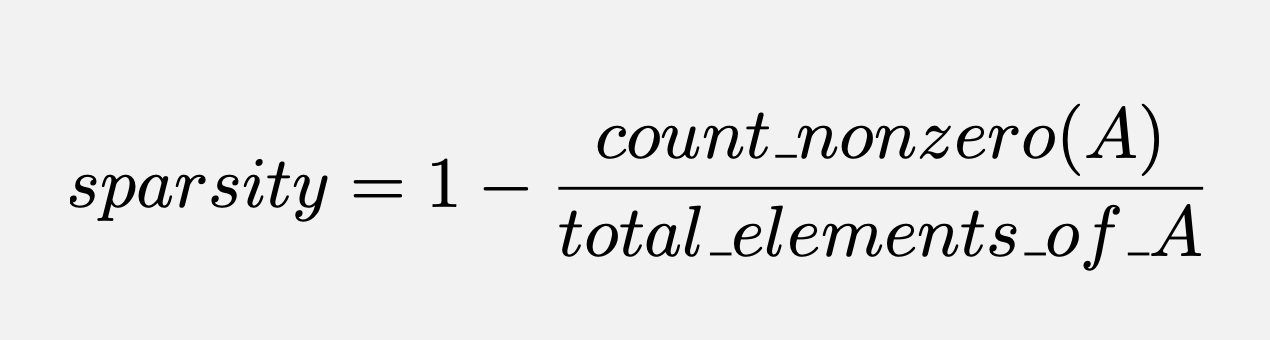

In [47]:
# Load the sparse matrix
if os.path.isfile('./data/train_sparse.npz'):
    train_sparse_matrix = sparse.load_npz('./data/train_sparse.npz')

In [48]:
train_sparse_matrix.shape

(2649430, 17771)

In [49]:
users,movies = train_sparse_matrix.shape
elements = train_sparse_matrix.count_nonzero()
sparsity = (1-(elements/(users*movies))) * 100
sparsity

99.8292709259195

#### Sparse Matrix for test data

In [51]:
start = datetime.now()
if not os.path.isfile('./data/test_sparse_matrix.npz'):
    print('Creating Sparse Matrix for Testing Data')
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values,(test_df.user.values,test_df.movie.values)),)
    print('Done: Shape of matrix : ',test_sparse_matrix.shape)
end = datetime.now()

print('Time taken : {}'.format(end-start))

Time taken : 0:00:00.000959


In [52]:
if not os.path.isfile('./data/test_sparse_matrix.npz'):
    sparse.save_npz('./data/test_sparse_matrix.npz',test_sparse_matrix)
# Load the sparse matrix
if os.path.isfile('./data/test_sparse_matrix.npz'):
    test_sparse_matrix = sparse.load_npz('./data/test_sparse_matrix.npz')

#### Sparsity of test data

In [53]:
users,movies = test_sparse_matrix.shape
elements = sparse_matrix.count_nonzero()
sparsity = (1-(elements/(users*movies))) * 100
sparsity

99.95731772988694

The matrix is 99 % sparse

#### Global Averages

We will now calculate the global mean of all the movies ratings

In [27]:
def get_average_ratings(sparse_matrix,calculate_for_users=True):
    if calculate_for_users:
        axis_to_consider = 1
    else:
        axis_to_consider = 0
        # .A1 to convert to 1-D np array
    sum_of_ratings = sparse_matrix.sum(axis = axis_to_consider).A1 
    movies_that_are_rated_matrix = sparse_matrix!=0
    no_of_ratings = movies_that_are_rated_matrix.sum(axis_to_consider).A1
    
    total_users,total_movies = sparse_matrix.shape
    # Calculate the average for users/movies
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i]
                      for i in range(total_users if calculate_for_users else total_movies)
                      if no_of_ratings[i]!=0
                      }
    return average_ratings

##### Global Average of all ratings

In [28]:
train_data_averages = {}
ratings_global_average = sparse_matrix.sum()/sparse_matrix.count_nonzero()
train_data_averages['global'] = ratings_global_average
train_data_averages

{'global': 3.582890686321557}

##### Average ratings per user

In [29]:
train_data_averages['user'] = get_average_ratings(sparse_matrix)
print('Average rating for user 210 : {}'.format(train_data_averages['user'][201]))

Average rating for user 210 : 3.605714285714286


##### Average ratings per movie

In [30]:
train_data_averages['movie'] = get_average_ratings(sparse_matrix)
print('Average rating for the movie 6 : {}'.format(train_data_averages['movie'][6]))

Average rating for the movie 6 : 3.5160550458715596


- ___The movie averages can tell us about the performance of the movie___
- ___The User averages can tell us about the ratings pattern for a particular user___

### Building the Model

#### Sampling data

In [31]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for further usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

#### Sample Train data

In [57]:
start = datetime.now()
path = "./data/sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your working directory, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 1k users and 500 movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(sparse_matrix, no_users=1000, no_movies=500,
                                             path = path)

print(datetime.now() - start)

Original Matrix : (users, movies) -- (349312 17757)
Original Matrix : Ratings -- 20096102

Sampled Matrix : (users, movies) -- (1000 500)
Sampled Matrix : Ratings -- 1388
Saving it into disk for further usage..
Done..

0:00:15.567383


#### Sample Test data

In [79]:
start = datetime.now()
path = "./data/sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your working directory, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 1k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=1000, no_movies=500,
                                             path = path)

print(datetime.now() - start)

It is present in your working directory, getting it from disk....
DONE..
0:00:00.034908


#### Averages for the sample data

In [80]:
sample_train_averages = dict()
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

# User rating Average
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, calculate_for_users=True)
print('\nAverage rating of user 23354 :',sample_train_averages['user'][23354])


Average rating of user 23354 : 4.363636363636363


In [81]:
# Movie Rating Average
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix,calculate_for_users=False)
print('\n AVerage rating of movie 348 :',sample_train_averages['movie'][348])


 AVerage rating of movie 348 : 4.0


### Feature Engineering

In [82]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our Sampled test matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 1388


 No of ratings in Our Sampled test matrix is : 1388



In [83]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [87]:
start = datetime.now()
if os.path.isfile('./data/reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('./data/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

preparing 1388 tuples for the dataset..

0:08:20.541729


The new features are :
- __global_average__ :  Average rating of all the ratings                                                           
- __sim_user_1-----sim_user_5__: Top 5 similar users who rated that movie
- __sim_mov_1---sim_mov_5__ : Top 5 similar movies rated by this movie.
- __user_averge_rating__ : User's Average rating
- __movie_average_rating__ : Average rating of this movie
- __rating__ : Rating of this movie by this user

In [89]:
reg_train_data = pd.read_csv('./data/reg_train.csv',names = ['user','movie',
                                                             'global_avg',
                                                             'sim_user_1',
                                                             'sim_user_2',
                                                             'sim_user_3',
                                                             'sim_user_4',
                                                             'sim_user_5',
                                                             'sim_mov_1',
                                                             'sim_mov_2',
                                                             'sim_mov_3',
                                                             'sim_mov_4',
                                                             'sim_mov_5',
                                                             'user_averge_rating',
                                                             'movie_average_rating',
                                                             'rating'])
reg_train_data.head()

,user,movie,global_avg,sim_user_1,sim_user_2,sim_user_3,sim_user_4,sim_user_5,sim_mov_1,sim_mov_2,sim_mov_3,sim_mov_4,sim_mov_5,user_averge_rating,movie_average_rating,rating
0,356035,111,3.596542,2.0,4.0,4.0,3.0,2.0,5.0,2.0,2.0,2.0,3.0,2.750000,3.111111,3
1,422234,111,3.596542,3.0,4.0,4.0,3.0,4.0,2.0,2.0,2.0,2.0,2.0,2.000000,3.111111,2
2,981995,111,3.596542,2.0,3.0,3.0,4.0,3.0,5.0,5.0,4.0,5.0,4.0,4.222222,3.111111,4
3,1083033,111,3.596542,3.0,3.0,2.0,3.0,3.0,3.0,4.0,4.0,3.0,4.0,3.347826,3.111111,2
4,1990451,111,3.596542,4.0,2.0,3.0,3.0,3.0,5.0,5.0,5.0,4.0,4.6,4.600000,3.111111,4


#### Features for the test data

In [90]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [91]:
start = datetime.now()

if os.path.isfile('./data/reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('./data/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

preparing 1388 tuples for the dataset..

Done for 1000 rows----- 0:05:49.401871
 0:08:19.086657


In [92]:
reg_test_data = pd.read_csv('./data/reg_test.csv',names = ['user','movie',
                                                             'global_avg',
                                                             'sim_user_1',
                                                             'sim_user_2',
                                                             'sim_user_3',
                                                             'sim_user_4',
                                                             'sim_user_5',
                                                             'sim_mov_1',
                                                             'sim_mov_2',
                                                             'sim_mov_3',
                                                             'sim_mov_4',
                                                             'sim_mov_5',
                                                             'user_averge_rating',
                                                             'movie_average_rating',
                                                             'rating'])
reg_test_data.head()

,user,movie,global_avg,sim_user_1,sim_user_2,sim_user_3,sim_user_4,sim_user_5,sim_mov_1,sim_mov_2,sim_mov_3,sim_mov_4,sim_mov_5,user_averge_rating,movie_average_rating,rating
0,356035,111,3.596542,2.0,4.0,4.0,3.0,2.0,5.0,2.0,2.0,2.0,3.0,2.750000,3.111111,3
1,422234,111,3.596542,3.0,4.0,4.0,3.0,4.0,2.0,2.0,2.0,2.0,2.0,2.000000,3.111111,2
2,981995,111,3.596542,2.0,3.0,3.0,4.0,3.0,5.0,5.0,4.0,5.0,4.0,4.222222,3.111111,4
3,1083033,111,3.596542,3.0,3.0,2.0,3.0,3.0,3.0,4.0,4.0,3.0,4.0,3.347826,3.111111,2
4,1990451,111,3.596542,4.0,2.0,3.0,3.0,3.0,5.0,5.0,5.0,4.0,4.6,4.600000,3.111111,4


### Surprise Library

We will make use of algorithms in the Suprise family  

In [36]:
reader = Reader(rating_scale=(1,5))

In [93]:
reg_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 16 columns):
user                    1388 non-null int64
movie                   1388 non-null int64
global_avg              1388 non-null float64
sim_user_1              1388 non-null float64
sim_user_2              1388 non-null float64
sim_user_3              1388 non-null float64
sim_user_4              1388 non-null float64
sim_user_5              1388 non-null float64
sim_mov_1               1388 non-null float64
sim_mov_2               1388 non-null float64
sim_mov_3               1388 non-null float64
sim_mov_4               1388 non-null float64
sim_mov_5               1388 non-null float64
user_averge_rating      1388 non-null float64
movie_average_rating    1388 non-null float64
rating                  1388 non-null int64
dtypes: float64(13), int64(3)
memory usage: 173.6 KB


#### Tranforming train data for Surprise Models

In [94]:
train_data = Dataset.load_from_df(reg_train_data[['user','movie','rating']],reader)
train_set_surprise = train_data.build_full_trainset()

#### Transforming test data for Surprise models

In [96]:
test_set_surprise = list(zip(reg_test_data.user.values, reg_test_data.movie.values, reg_test_data.rating.values))
test_set_surprise[:3]

[(356035, 111, 3), (422234, 111, 2), (981995, 111, 4)]

In [97]:
benchmark = []
for algorithm in [SVD(),
                  CoClustering(),
                  BaselineOnly(),
                  KNNBaseline(),
                  KNNBasic(),
                  KNNWithMeans(),
                  NormalPredictor()
#                   NMF()
                 ]:
    result = cross_validate(algorithm,train_data,measures=['RMSE'],cv=3,verbose=False)
    results_df = pd.DataFrame.from_dict(result).mean(axis=0)
    results_df = results_df.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(results_df)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [98]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.998900,0.067817,0.004322
BaselineOnly,1.016523,0.005984,0.004321
KNNBaseline,1.082104,0.015626,0.024267
KNNBasic,1.113009,0.007979,0.014960
CoClustering,1.141728,0.076462,0.003991
KNNWithMeans,1.149201,0.013962,0.012966
NormalPredictor,1.472623,0.001661,0.004322


SVD algorithm has the least test_rmse

#### Get the predictions for SVD model

In [99]:
st = datetime.now()
print('Training the model...')
svd_model = SVD()
svd_model.fit(train_set_surprise)
print('Done. time taken : {} \n'.format(datetime.now()-st))

Training the model...
Done. time taken : 0:00:00.107768 



In [112]:
svd_train_preds_raw = svd_model.test(train_set_surprise.build_testset())

svd_train_preds = np.array([pred.est for pred in svd_train_preds_raw])

In [113]:
svd_test_preds_raw = svd_model.test(test_set_surprise)

svd_test_preds = np.array([pred.est for pred in svd_test_preds_raw])

### Using training/test predictions as a feature for next Model

In [109]:
reg_train_data['preds'] = svd_train_preds
reg_train_data.head()

,user,movie,global_avg,sim_user_1,sim_user_2,sim_user_3,sim_user_4,sim_user_5,sim_mov_1,sim_mov_2,sim_mov_3,sim_mov_4,sim_mov_5,user_averge_rating,movie_average_rating,rating,preds
0,356035,111,3.596542,2.0,4.0,4.0,3.0,2.0,5.0,2.0,2.0,2.0,3.0,2.750000,3.111111,3,2.941570
1,422234,111,3.596542,3.0,4.0,4.0,3.0,4.0,2.0,2.0,2.0,2.0,2.0,2.000000,3.111111,2,3.116763
2,981995,111,3.596542,2.0,3.0,3.0,4.0,3.0,5.0,5.0,4.0,5.0,4.0,4.222222,3.111111,4,2.518408
3,1083033,111,3.596542,3.0,3.0,2.0,3.0,3.0,3.0,4.0,4.0,3.0,4.0,3.347826,3.111111,2,3.065859
4,1990451,111,3.596542,4.0,2.0,3.0,3.0,3.0,5.0,5.0,5.0,4.0,4.6,4.600000,3.111111,4,3.635044


In [120]:
reg_test_data['preds'] = svd_test_preds
reg_test_data.head()

,user,movie,global_avg,sim_user_1,sim_user_2,sim_user_3,sim_user_4,sim_user_5,sim_mov_1,sim_mov_2,sim_mov_3,sim_mov_4,sim_mov_5,user_averge_rating,movie_average_rating,rating,preds
0,356035,111,3.596542,2.0,4.0,4.0,3.0,2.0,5.0,2.0,2.0,2.0,3.0,2.750000,3.111111,3,2.941570
1,422234,111,3.596542,3.0,4.0,4.0,3.0,4.0,2.0,2.0,2.0,2.0,2.0,2.000000,3.111111,2,2.844820
2,981995,111,3.596542,2.0,3.0,3.0,4.0,3.0,5.0,5.0,4.0,5.0,4.0,4.222222,3.111111,4,3.741656
3,1083033,111,3.596542,3.0,3.0,2.0,3.0,3.0,3.0,4.0,4.0,3.0,4.0,3.347826,3.111111,2,2.854758
4,1990451,111,3.596542,4.0,2.0,3.0,3.0,3.0,5.0,5.0,5.0,4.0,4.6,4.600000,3.111111,4,3.853232


#### XGBoost with 13 features + Predictions of SVD Model

In [122]:
X_train = reg_train_data.drop(['user', 'movie', 'rating'],axis = 1)
y_train = reg_train_data.rating

X_test = reg_test_data.drop(['user', 'movie', 'rating'],axis = 1)
y_test = reg_test_data.rating

xgbreg = xgb.XGBRegressor(n_jobs=10,random_state=2,n_estimators=100)
xgbreg.fit(X_train,y_train,eval_metric='rmse')
y_pred = xgbreg.predict(X_test)

[18:38:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [130]:
mse = mean_squared_error(y_test,y_pred)

In [131]:
rmse = np.sqrt(mse)
print('Root Mean Square Error : {}'.format(rmse))

Root Mean Square Error : 0.5661173289291949


So we have achieved a Root Mean Square Error of 0.5661173289291949